In [15]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [273]:
def fetch_poster(movie_id):
    pattern = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q={movie_title}'
    url = pattern.format(movie_title=urllib.parse.quote(movie_id))
    r = requests.get(url)
    res = r.json()
    for section in ['popular','exact','substring']:
        key = 'title_' + section 
        if key in res:
            return res[key][0]['id']

In [16]:
df= pd.read_csv('imdb_movies.csv')
df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


# Data Preprocessing 🧹

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


**handling missing value**

In [18]:
df.isnull().sum()[df.isnull().sum()>0]

genre    85
crew     56
dtype: int64

In [19]:
index_to_drop = (df.loc[df['genre'].isnull() | 
                             df['crew'].isnull()]).index

df = df.drop(index_to_drop).reset_index(drop=True)

df.loc[df['genre'].isnull() | df['crew'].isnull()]

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country


In [20]:
df[df.duplicated()]

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country


In [21]:
df.shape

(10052, 12)

In [22]:
df.rename(columns= {'date_x':'date'}, inplace=True)

# Exploratory Data Analysis 📚

**Exploring Variable Relationships: Spearman Correlation Heatmap**

In [23]:
df.describe()

,score,budget_x,revenue
count,10052.00000,1.005200e+04,1.005200e+04
mean,63.82700,6.412528e+07,2.512049e+08
std,12.78271,5.665852e+07,2.765495e+08
min,0.00000,1.000000e+00,0.000000e+00
25%,59.00000,1.439763e+07,2.768781e+07
50%,65.00000,5.000000e+07,1.493288e+08
75%,71.00000,1.040000e+08,4.161578e+08
max,100.00000,4.600000e+08,2.923706e+09


In [24]:
numeric= df.select_dtypes(include=np.number).columns.tolist()
numeric

['score', 'budget_x', 'revenue']

In [25]:
df.select_dtypes(include='object').columns.tolist()

['names',
 'date',
 'genre',
 'overview',
 'crew',
 'orig_title',
 'status',
 'orig_lang',
 'country']

In [26]:
## subset categorical variables which you want to encode
Cat= df[['status', 'orig_lang', 'country']]

from sklearn.preprocessing import LabelEncoder
# Assigning numerical values and storing in another column
Cat = Cat.apply(LabelEncoder().fit_transform)
Cat

,status,orig_lang,country
0,2,12,2
1,2,12,2
2,2,12,2
3,2,44,2
4,2,12,52
...,...,...,...
10047,2,12,52
10048,2,12,52
10049,2,12,52
10050,2,12,52


In [27]:
heatmap= df[numeric]
#heatmap= heatmap.drop(Cat.columns, axis= 1)
heatmap= pd.concat([heatmap, Cat], axis= 1)
heatmap.columns

Index(['score', 'budget_x', 'revenue', 'status', 'orig_lang', 'country'], dtype='object')

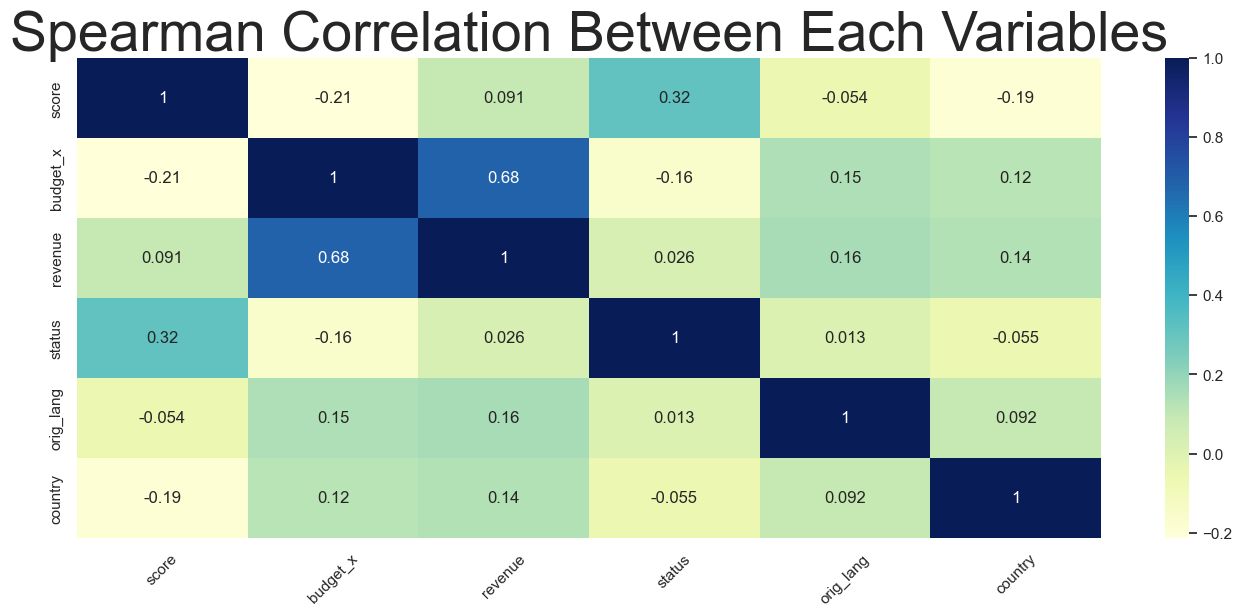

In [28]:
attr = heatmap.columns.tolist()
sns.set_theme()

# Spearman’s ρ 
x = heatmap[attr].corr()
fig = plt.figure(figsize =(16, 6)) 
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
sns.heatmap(x, cmap='YlGnBu', annot=True, ax=ax)
plt.xticks(rotation = 45)
plt.title('Spearman Correlation Between Each Variables', fontsize = 40)
plt.show()

> Notable findings include a strong positive correlation **_0.68_** between `revenue` and `budget_x`, indicating The higher the budget spent, the more revenue you get. A positive correlation **_0.32_** between `status` and `score` shows after the film is released, score tend to increase.

In [29]:
df.groupby('genre')['score'].agg(['mean', 'median', ('mode',lambda x: x.mode().iloc[0])])

,mean,median,mode
genre,,,
Action,59.802326,61.0,64.0
"Action, Adventure",62.166667,61.5,58.0
"Action, Adventure, Animation",62.333333,62.0,58.0
"Action, Adventure, Animation, Comedy",69.000000,69.0,69.0
"Action, Adventure, Animation, Comedy, Family",68.000000,68.0,67.0
...,...,...,...
"Western, Horror",68.000000,68.0,68.0
"Western, Horror, Mystery",63.000000,63.0,63.0
"Western, Mystery",56.000000,56.0,56.0


In [30]:
data= df[['genre', 'overview']]
data.head()

,genre,overview
0,"Drama, Action","After dominating the boxing world, Adonis Cree..."
1,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...
2,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,..."
3,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ..."
4,Action,Good-hearted teenager William always lived in ...


In [31]:
#import spacy
#spacy.cli.download("en_core_web_md")
#nlp_model = spacy.load("en_core_web_md")

In [98]:
nlp_model = spacy.load("en_core_web_md")
nlp_model.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [33]:
def lemmatizer(text):
    # Convert to lowercase
    lower_case = text.lower()

    # Lemmatization and Remove Stop Words
    tokens = [token.lemma_ for token in nlp_model(lower_case) if not token.is_stop]

    # Sentence Formation
    sentence = " ".join(tokens)
    return sentence

def doc2vec(text):
    # Lemmatization
    text = lemmatizer(text)

    # Initialize a vector with zeros
    vector = np.zeros(len(nlp_model('').vector))
    
    # Tokenize the lemmatized text
    tokens = nlp_model(text)
    len_of_text = len(tokens)

    if len_of_text > 0:
        # Calculate the weighted vector
        for token in tokens:            
            vector = vector + token.vector
        vector = vector / len_of_text
    return vector


def map_genre_to_doc2vec(df):
    # Extract the genre definitions from the DataFrame
    overview = list(df['overview'])
    
    # Get the dimensions for the resulting Doc2Vec vectors
    rows, cols = len(overview), len(nlp_model('').vector)
    
    # Initialize an array to store the Doc2Vec vectors
    doc2vec_genre = np.zeros(rows*cols).reshape(rows, cols)

    # Calculate the Doc2Vec vector for each genre definition
    for i, text in enumerate(overview):
        vector = doc2vec(text)
        doc2vec_genre[i] = vector
    return doc2vec_genre

In [34]:
genre_vector = map_genre_to_doc2vec(data)
print("doc2vec representation of genre#1: ", genre_vector[0][0:5])
print("doc2vec representation of genre#2: ", genre_vector[1][0:5])
print("doc2vec representation of genre#3: ", genre_vector[2][0:5])
print("doc2vec representation of genre#4: ", genre_vector[3][0:5])
print(genre_vector.shape)

doc2vec representation of genre#1:  [-1.60056263 -0.31725877 -1.7154427   0.05008394  3.2572261 ]
doc2vec representation of genre#2:  [-1.48679851 -1.03251649 -1.05152889 -0.74455515  1.54550659]
doc2vec representation of genre#3:  [-0.98070731 -0.14769315 -1.03793807 -1.38536421  2.58232743]
doc2vec representation of genre#4:  [-1.1882646  -0.40456039 -0.9901837  -1.1325589   3.12538838]
(10052, 300)


In [134]:
pickle.dump(genre_vector, open('scapy_preprocessing.pkl', 'wb'))

Text(0.5, 1.0, 'Elbow curve')

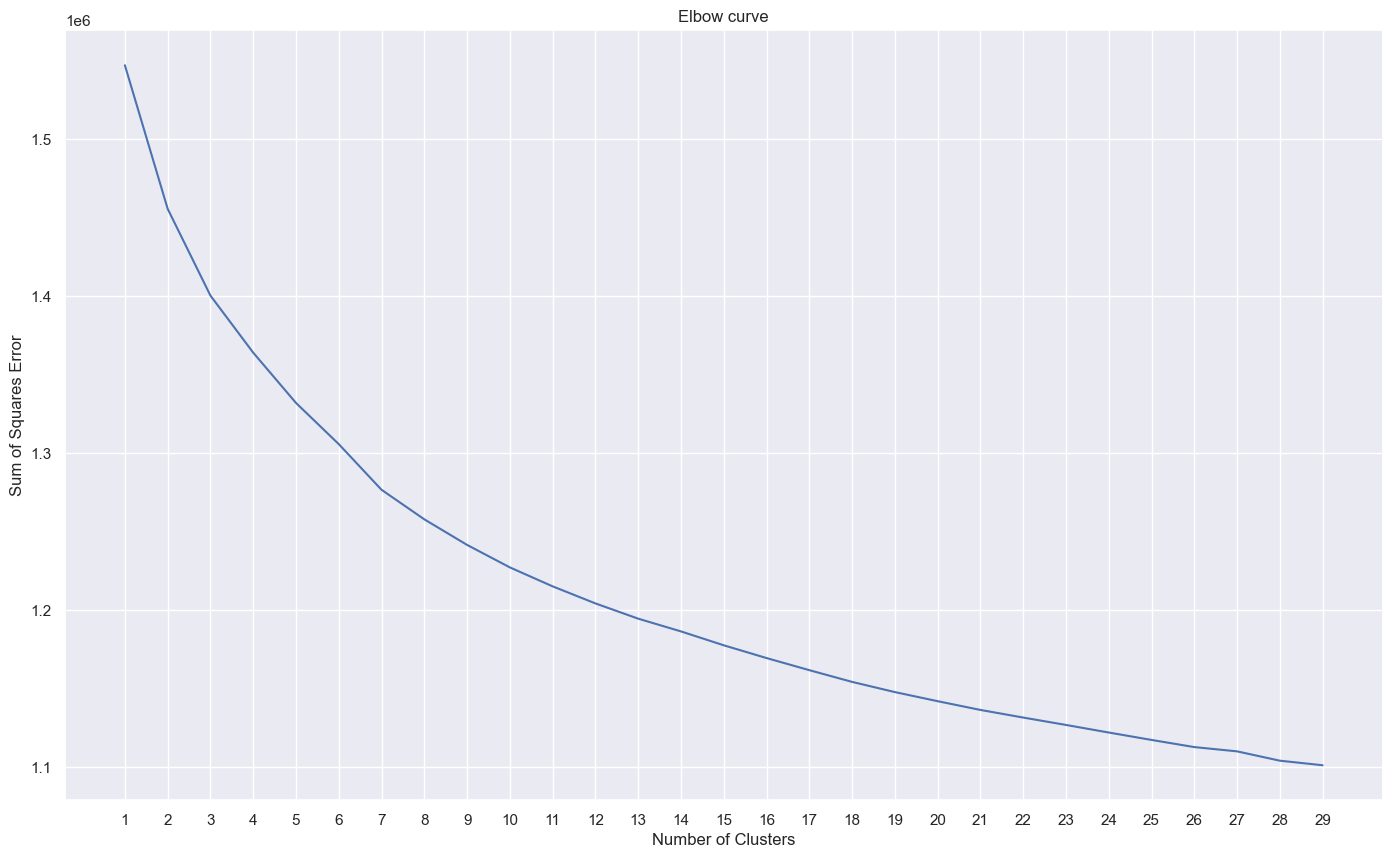

In [35]:
# Initialize empty lists to store sum of squares and cluster values
sum_of_squares = []
clusters = []

# Define a range of cluster values to test (from 20 to 39)
iteration = range(1, 30)
clusters.extend(iteration)

# Iterate through different cluster values
for k in iteration:
    # Create a KMeans model with specified parameters
    model = KMeans(
        n_clusters=k,             # Number of clusters
        init='k-means++',         # Initialization method
        n_init=10,                # Number of re-run with different initializations
        max_iter=100,             # Maximum number of iterations for each run
        tol=1e-3,                 # Tolerance to declare convergence
        random_state=42,         # Random seed for reproducibility
    )

    # Fit the KMeans model to the genre vectors
    model.fit(genre_vector)
    # Append the sum of squares error to the list
    sum_of_squares.append(model.inertia_)

# Plotting elbow curve
sns.set(style='darkgrid')
fig = plt.figure(figsize=(17, 10))
plt.plot(clusters, sum_of_squares)
plt.grid(True)
plt.xticks(np.arange(min(clusters), max(clusters) + 1, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Error')
plt.title('Elbow curve')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

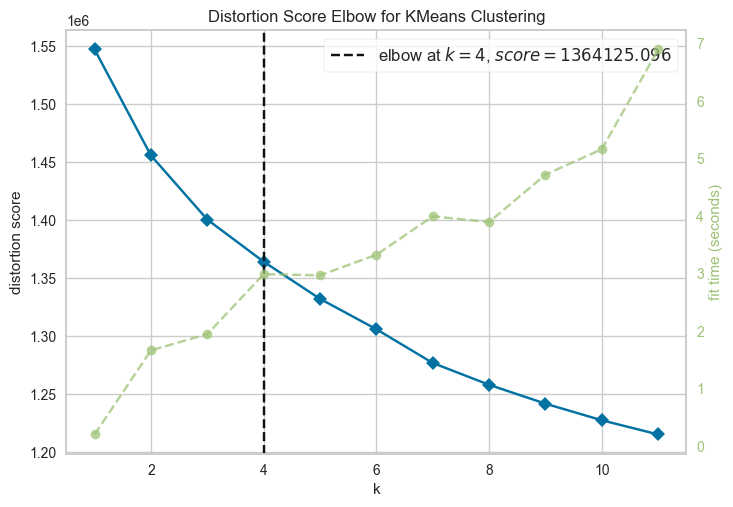

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(genre_vector)        # Fit the data to the visualizer
visualizer.show()

In [37]:
model = KMeans(
    n_clusters=4, 
    init='k-means++',
    n_init=10, 
    max_iter=100,
    tol=1e-3,
    random_state=42, 
    )
model.fit(genre_vector)

data['cluster'] = model.labels_
data = data[['genre','cluster','overview']]
data

C:\Users\user\AppData\Local\Temp\ipykernel_12476\1764507766.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = model.labels_


,genre,cluster,overview
0,"Drama, Action",0,"After dominating the boxing world, Adonis Cree..."
1,"Science Fiction, Adventure, Action",0,Set more than a decade after the events of the...
2,"Animation, Adventure, Family, Fantasy, Comedy",0,"While working underground to fix a water main,..."
3,"Animation, Comedy, Family, Adventure, Fantasy",2,"Through a series of unfortunate events, three ..."
4,Action,0,Good-hearted teenager William always lived in ...
...,...,...,...
10047,Drama,0,"In 1979 Santa Barbara, California, Dorothea Fi..."
10048,Action,3,When DEA agents are taken captive by a ruthles...
10049,"Drama, Thriller, Romance",2,"Barley Scott Blair, a Lisbon-based editor of R..."
10050,"Action, Adventure, Science Fiction, Thriller, ...",3,Darkman and Durant return and they hate each o...


In [38]:
result_dict = data.groupby('cluster')['genre'].apply(list).to_dict()
genre_cluster = pd.DataFrame(result_dict.items(), columns=['Cluster', 'Genres'])

genre_cluster

,Cluster,Genres
0,0,"[Drama, Action, Science Fiction, Adventure, Ac..."
1,1,"[Animation, Family, Fantasy, Adventure, Comedy..."
2,2,"[Animation, Comedy, Family, Adventure, Fantasy..."
3,3,"[Action, Thriller, Crime, Action, Science Fict..."


In [39]:
data

,genre,cluster,overview
0,"Drama, Action",0,"After dominating the boxing world, Adonis Cree..."
1,"Science Fiction, Adventure, Action",0,Set more than a decade after the events of the...
2,"Animation, Adventure, Family, Fantasy, Comedy",0,"While working underground to fix a water main,..."
3,"Animation, Comedy, Family, Adventure, Fantasy",2,"Through a series of unfortunate events, three ..."
4,Action,0,Good-hearted teenager William always lived in ...
...,...,...,...
10047,Drama,0,"In 1979 Santa Barbara, California, Dorothea Fi..."
10048,Action,3,When DEA agents are taken captive by a ruthles...
10049,"Drama, Thriller, Romance",2,"Barley Scott Blair, a Lisbon-based editor of R..."
10050,"Action, Adventure, Science Fiction, Thriller, ...",3,Darkman and Durant return and they hate each o...


In [40]:
df['cluster'] = data['cluster']
df.head()

,names,date,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,cluster
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,0
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,0
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,0
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU,2
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US,0


**Analyzing Revenue in Genre Clusters**

In [41]:
df.groupby('cluster')['score'].mean().sort_values(ascending= False)

cluster
0    64.808043
3    64.167598
2    63.275393
1    62.817333
Name: score, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_12476\2809573530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(data=df, y='cluster', x='score', orient='h', palette='Blues_r', order=order)


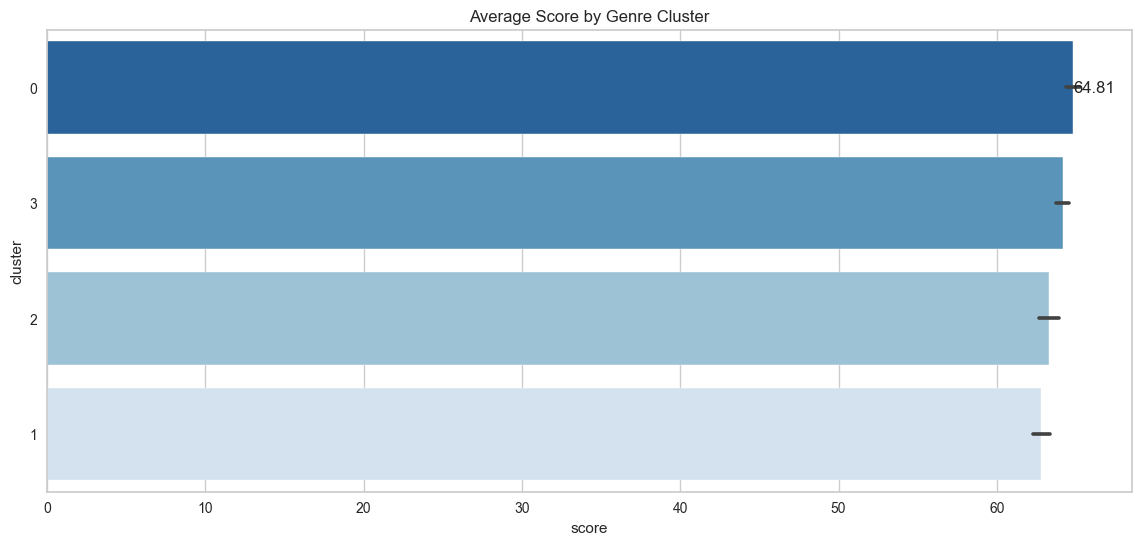

In [62]:
plt.figure(figsize=(14,6))
order = df.groupby('cluster')['score'].mean().sort_values(ascending=False).index
plot = sns.barplot(data=df, y='cluster', x='score', orient='h', palette='Blues_r', order=order)
plot.set_title('Average Score by Genre Cluster')
plot.bar_label(plot.containers[0], fmt='%.2f')
plt.show()

In [74]:
genre_cluster.to_csv('genre_cluster.csv')

`Cluster 0` gave the highest average score of **64.8%**

**Standarization for Modeling**

In [45]:
def applyStandardScaler(data, attributes):
    for attr in attributes:
        data[attr+'_scaled'] = StandardScaler().fit_transform(data[[attr]])
        
attributes =heatmap.columns.tolist()  
applyStandardScaler(data= heatmap, attributes=attributes)

**Using One Hot Encoding**

In [46]:
one_hot_genre = pd.get_dummies(df['cluster'], prefix='g_cluster')
one_hot_genre.head()

,g_cluster_0,g_cluster_1,g_cluster_2,g_cluster_3
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,False,False,True,False
4,True,False,False,False


In [47]:
heatmap.columns

Index(['score', 'budget_x', 'revenue', 'status', 'orig_lang', 'country',
       'score_scaled', 'budget_x_scaled', 'revenue_scaled', 'status_scaled',
       'orig_lang_scaled', 'country_scaled'],
      dtype='object')

**Feature Selection**

In [48]:
attr = ['revenue_scaled', 'budget_x_scaled', 'status_scaled',
       'orig_lang_scaled', 'country_scaled']

y = heatmap['score_scaled']

#features
x1 = heatmap[attr] 
x1[one_hot_genre.columns] = one_hot_genre

x1.columns

C:\Users\user\AppData\Local\Temp\ipykernel_12476\1490991826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1[one_hot_genre.columns] = one_hot_genre
C:\Users\user\AppData\Local\Temp\ipykernel_12476\1490991826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1[one_hot_genre.columns] = one_hot_genre
C:\Users\user\AppData\Local\Temp\ipykernel_12476\1490991826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Index(['revenue_scaled', 'budget_x_scaled', 'status_scaled',
       'orig_lang_scaled', 'country_scaled', 'g_cluster_0', 'g_cluster_1',
       'g_cluster_2', 'g_cluster_3'],
      dtype='object')

**Hyperparameter Tuning**

In [59]:
percent = 25
cv_percent = int(x1.shape[0]//(x1.shape[0]*percent/100))


param_grid = {
        'n_estimators': [400],
        'max_depth': [None],
        'min_samples_split': [2,4],
        'min_samples_leaf': [4],
        'n_jobs': [-1]
    }


rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv_percent, verbose=1)
grid_search.fit(x1, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 4 folds for each of 2 candidates, totalling 8 fits


({'max_depth': None,
  'min_samples_leaf': 4,
  'min_samples_split': 4,
  'n_estimators': 400,
  'n_jobs': -1},
 0.5115469941638204)

**Model Training & Evaluation**

In [60]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

best_params = {
        'max_depth': None,             # Maximum depth of each tree in the forest
        'min_samples_leaf': 4,         # Minimum no of samples required to be at a leaf node
        'min_samples_split': 2,        # Minimum no of samples required to split an internal node
        'n_estimators': 200,           # Number of trees in the random forest
        'random_state': 42,           # Seed for random number generation 
        'n_jobs': -1                   # Number of CPU cores to use for parallel computation
    }

rf1 = RandomForestRegressor(    
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=best_params['random_state'],
    n_jobs=-1
)
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.25, random_state=42)
# Fit the decision tree regressor on the training data
rf1.fit(x_train, y_train)
# Predict on the testing data
y_pred = rf1.predict(x_test)
# Calculate the mean squared error and root mean squared error
mse = skm.mean_squared_error(y_test, y_pred)
rmse = skm.mean_squared_error(y_test, y_pred, squared=False)
# Calculate the mean absolute error
mae = skm.mean_absolute_error(y_test, y_pred)
# Calculate the max error
mxe = skm.max_error(y_test, y_pred)
r2 = skm.r2_score(y_test, y_pred)
rmse, mse, mae, mxe, r2

(0.656432654808469,
 0.4309038302988947,
 0.49751077543763517,
 5.043158072249534,
 0.5501749300993012)

**Feature Importance**

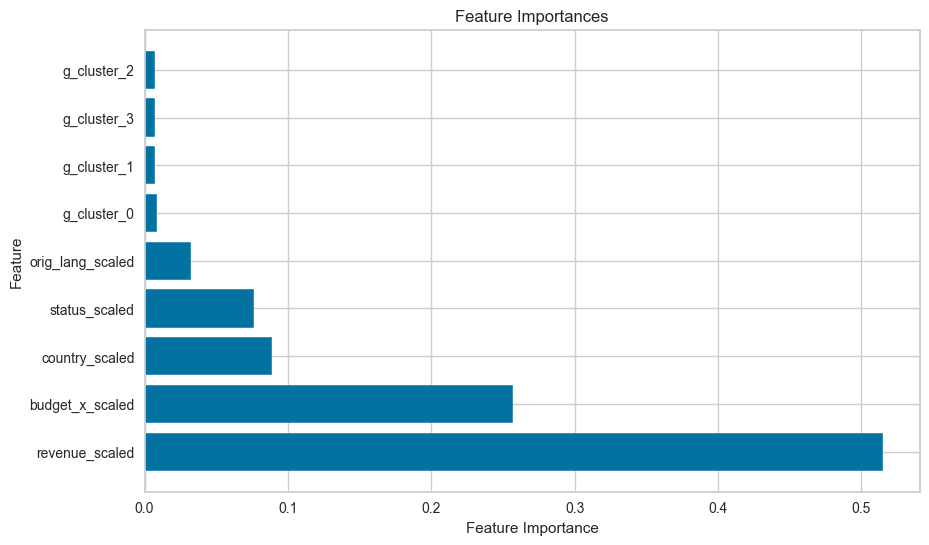

In [61]:
feature_importances = rf1.feature_importances_
feature_names = x1.columns
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [268]:
importance= pd.DataFrame(columns=(['columns','Feature Importance']))
importance['columns']= x1.columns
importance['Feature Importance']= feature_importances
importance

,columns,Feature Importance
0,revenue_scaled,0.514798
1,budget_x_scaled,0.256831
2,status_scaled,0.076321
3,orig_lang_scaled,0.032266
4,country_scaled,0.088768
5,g_cluster_0,0.008924
6,g_cluster_1,0.007595
7,g_cluster_2,0.007152
8,g_cluster_3,0.007344


In [269]:
importance.to_csv('feature_importance.csv')

**Recommendation System**

In [90]:
df_2 = data[['genre', 'overview']]
df_2

,genre,overview
0,"Drama, Action","After dominating the boxing world, Adonis Cree..."
1,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...
2,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,..."
3,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ..."
4,Action,Good-hearted teenager William always lived in ...
...,...,...
10047,Drama,"In 1979 Santa Barbara, California, Dorothea Fi..."
10048,Action,When DEA agents are taken captive by a ruthles...
10049,"Drama, Thriller, Romance","Barley Scott Blair, a Lisbon-based editor of R..."
10050,"Action, Adventure, Science Fiction, Thriller, ...",Darkman and Durant return and they hate each o...


In [91]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
def clean_desc(s):
    s = str(s)
    s = s.lower()
    s = re.sub(r'[^a-zA-Z]', ' ', s)
    s= re.sub('[+-]?[0-9]+','',s)
    return s
  
# make a copy of the main data and do the preprocessing steps on that data
df_2['clean_desc'] = df_2['overview'].apply(clean_desc)

#tokenizing the words for lemmatization and removing stopwords
df_2['clean_desc'] = df_2['clean_desc'].apply(word_tokenize)
df_2['clean_desc'] = df_2['clean_desc'].apply(
  lambda x:[word for word in x if word not in set(stopwords.words('english'))]
)

# joining the words after lemmatization and stopword removal
df_2['clean_desc'] = df_2['clean_desc'].apply(lambda x: ' '.join(x))

**Stemming**

In [176]:
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))

    return " ".join(y)

**Lemmatization**

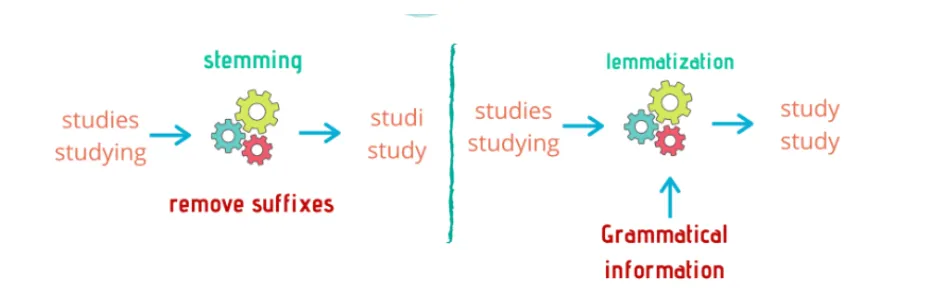

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")
# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()
# Example inflections to reduce
example_words = ["program","programming","programer","programs","programmed"]
# Perform lemmatization
print("{0:20}{1:20}".format("--Word--","--Lemma--"))
for word in example_words:
   print ("{0:20}{1:20}".format(word, wnl.lemmatize(word, pos="v")))

"""
--Word--            --Lemma--           
program             program             
programming         program             
programer           programer           
programs            program             
programmed          program
"""   

In [178]:
genre_cluster= map_genre_to_doc2vec(df_2)

In [179]:
df_2['clean_desc'] = df_2['clean_desc'].apply(stem)

In [228]:
tfidf = TfidfVectorizer(min_df = 1, max_df = 0.7)

X = tfidf.fit_transform(df_2['clean_desc'])

tfidf_df = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df.index = df['names']
tfidf_df.to_csv("tfidf_data.csv")

In [ ]:
df_2['names']= df['names']
df_2.drop('genre', axis= 1, inplace= True)

In [183]:
df_2= df_2[['names', 'overview', 'clean_desc']]

**CountVectorizer**

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
countvec = vectorizer.fit_transform(df_2['clean_desc'])
countvectorizer= countvec.toarray()

In [230]:
vectors= X.toarray()


**Eucledian distance not a good option for higher dimensionality - the solution is using cosine distance**

In [236]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)
similarity2 = cosine_similarity(countvectorizer)

In [221]:
similarity.shape

(10052, 10052)

In [213]:
def recommend_scapy(movie):
    index = df_2[df_2['names'] == movie].index[0]
    distances = sorted(list(enumerate(genre_vector[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(df_2.iloc[i[0]].names)

In [297]:
def recommend_tfidf(movie):
    index = df_2[df_2['names'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:20]:
        print(df_2.iloc[i[0]].names)
        

In [300]:
def recommend(movie):
    movie_index = df[df['names'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:20]

    recommended_movies = []
    scores = []
    for i in movies_list:
        recommended_movies.append(df.iloc[i[0]].orig_title)
        scores.append(df.iloc[i[0]].score)

    return recommended_movies,scores

In [304]:
scores= recommend('The Dark Knight Rises')[1]
scores

[75.0,
 75.0,
 85.0,
 64.0,
 67.0,
 77.0,
 71.0,
 72.0,
 75.0,
 77.0,
 43.0,
 73.0,
 67.0,
 73.0,
 54.0,
 72.0,
 72.0,
 75.0,
 77.0]

In [298]:
recommend_tfidf('Batman')

The Batman vs. Dracula
The Dark Knight
Batman Returns
Batman Beyond: Return of the Joker
Batman Unmasked: The Psychology of 'The Dark Knight'
Batman Begins
The Batman
Lego DC Batman: Family Matters
Batman: Under the Red Hood
Batman: Gotham by Gaslight
Batman: The Killing Joke
Batman: The Long Halloween, Part Two
Batman: The Dark Knight Returns, Part 1
Batman & Robin
The Marine 2
Hummingbird
The Dark Knight Rises
Batman: Death in the Family
Batman: Mystery of the Batwoman


In [237]:
import pickle

pickle.dump(df_2,open('movies.pkl','wb'))
pickle.dump(df_2.to_dict(),open('movie_dict.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))

In [191]:

import pickle
import pandas as pd
import streamlit as st
from streamlit import session_state as session

In [299]:
df.iloc[0].score

73.0

In [ ]:
# Fetch the neccesary python modules
import streamlit as st
import pickle
import pandas as pd
import requests

# Recommend movies based on content
def recommend(movie):
    movie_index = movies[movies['original_title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]

    recommended_movies = []
    recommended_movies_poster = []

    # Fetch the posters for each recommended movie
    for  i in movies_list:
        movie_id = movies.iloc[i[0]].id
        recommended_movies.append(movies.iloc[i[0]].original_title)
        recommended_movies_poster.append(fetch_poster(movie_id))

    return recommended_movies,recommended_movies_poster

# Load the necessary python pickle files
movies_dict = pickle.load(open('pickle/movie_dict.pkl','rb'))
movies = pd.DataFrame(movies_dict)

similarity = pickle.load(open('pickle/similarity.pkl','rb'))
Next, we will fetch the posters of these movies by using the TMDb API. You can create your very own API by logging into the TMDb developers API-3 site. Remember to replace the API key (in line 3 below) with your own key.

# Fetch posters from the TMDb database
def fetch_poster(movie_id):
    response = requests.get('https://api.themoviedb.org/3/movie/{}?api_key=ENTER_API_KEY_HERE&language=en-US'.format(movie_id))
    data = response.json()
    return "https://image.tmdb.org/t/p/w500/" + data['poster_path']

# Web app's hero section - Display Title, Dropdown
st.title("Movie Recommender System")

selected_movie_name = st.selectbox(
'Select a movie to recommend',
movies['original_title'].values)

# Output recommendations with posters
if st.button('Recommend'):
    name, posters = recommend(selected_movie_name)
 
    col1, col2, col3, col4,  col5 = st.columns(5)
    with col1:
        st.text(name[0])
        st.image(posters[0])
    with col2:
        st.text(name[1])
        st.image(posters[1])
    with col3:
        st.text(name[2])
        st.image(posters[2])
    with col4:
        st.text(name[3])
        st.image(posters[3])
    with col5:
        st.text(name[4])
        st.image(posters[4])

In [271]:
df_2.to_csv('df_2.csv')